# Compositional analysis of epithelial cells CeD vs Ctrl

Tool used: scCODA
https://sccoda.readthedocs.io/en/latest/getting_started.html

In [1]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

## Load data

In [3]:
# Load data

cell_counts = pd.read_csv('../subclustering/outputs/epithelial_cells_counts.csv')
cell_counts

,sample,age,sex,batch,status,?,EEC A/M,EEC D,EEC I,EEC K,...,Enterocytes mature (zone 4),Enterocytes mature (zone 5),Goblet cells,Paneth cells,Stem cells 1,Stem cells 2,TA cells 1,TA cells 2,Tuft cells,BEST4 cells
0,CeD1,10,M,A,CeD,12,5,21,7,8,...,37,1,4,78,164,32,74,73,30,0
1,CeD2,14,F,A,CeD,3,8,22,10,11,...,55,21,11,5,144,39,49,45,58,8
2,CeD2,14,F,F,CeD,0,2,4,3,3,...,18,17,4,0,155,24,52,24,7,3
3,CeD3,14,F,A,CeD,38,24,5,100,3,...,288,95,6,7,202,133,59,63,70,31
4,CeD4,17,F,A,CeD,9,11,4,3,1,...,8,1,15,39,75,38,47,22,11,0
5,CeD4,17,F,F,CeD,1,6,3,7,4,...,3,0,11,6,22,10,41,16,9,1
6,Ctrl1,15,F,A,Ctrl,9,16,8,11,31,...,316,98,6,55,78,103,28,19,100,20
7,Ctrl1,15,F,F,Ctrl,2,16,12,9,3,...,176,28,4,22,128,73,41,29,55,10
8,Ctrl2,11,M,F,Ctrl,2,9,19,11,10,...,288,241,10,12,148,162,71,39,64,8
9,Ctrl4,12,M,A,Ctrl,5,4,2,14,0,...,234,305,28,9,93,94,20,13,48,25


In [3]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns = ['sample'])

# Extract condition sample name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["sample"].str.replace(r"_[0-9]", "", regex=True)
print(data_all)

AnnData object with n_obs × n_vars = 8 × 22
    obs: 'sample', 'Condition'


In [4]:
print(data_all.obs)

   sample Condition
0  Ctrl_1      Ctrl
1  Ctrl_2      Ctrl
2   CeD_3       CeD
3   CeD_4       CeD
4  Ctrl_4      Ctrl
5  Ctrl_5      Ctrl
6   CeD_1       CeD
7   CeD_2       CeD


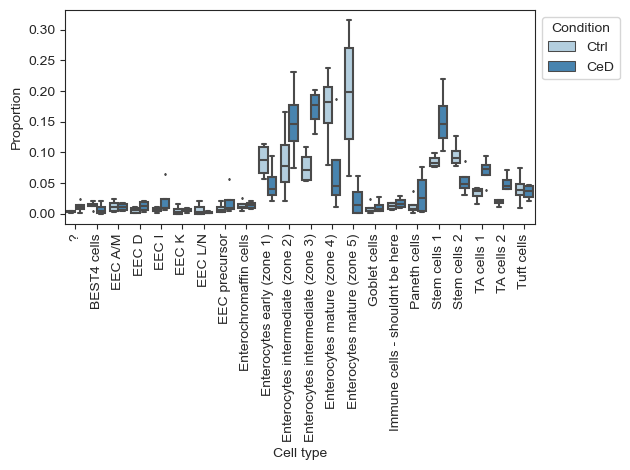

In [5]:
# Plotting the raw data
viz.boxplots(data_all, feature_name="Condition")
plt.show()

## Model setup and inference - using Goblet cells as reference

In [6]:
# Creating the model considering condition as covariate and goblet as reference cell type
# To set the reference level: "C(<CovariateName>, Treatment('<ReferenceLevelName>'))"
model = mod.CompositionalAnalysis(data_all, formula="C(Condition, Treatment('Ctrl'))", reference_cell_type="Goblet cells")

Zero counts encountered in data! Added a pseudocount of 0.5.


In [7]:
# Run MCMH
sim_results = model.sample_hmc()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:30<00:00, 220.06it/s]


MCMC sampling finished. (115.964 sec)
Acceptance rate: 39.3%


## Model setup and inference - using automatic reference

In [9]:
model_auto = mod.CompositionalAnalysis(data_all, formula="C(Condition, Treatment('Ctrl'))", reference_cell_type="automatic")
auto_results = model_auto.sample_hmc()

Automatic reference selection! Reference cell type set to Immune cells - shouldnt be here
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:25<00:00, 232.71it/s]


MCMC sampling finished. (110.666 sec)
Acceptance rate: 51.8%


## Checking the results

In [10]:
# Goblet as reference model
sim_results.summary()

Compositional Analysis summary:

Data: 8 samples, 22 cell types
Reference index: 14
Formula: C(Condition, Treatment('Ctrl'))

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.397        12.776194
BEST4 cells                                  0.005        19.097999
EEC A/M                                      0.020        19.386629
EEC D                                       -0.259        14.666758
EEC I                                       -0.081        17.524214
EEC K                                       -0.592        10.512695
EEC L/N                                     -0.842         8.187295
EEC precursor                               -0.108        17.057391
Enterochromaffin cells                       0.186        22.887332
Enterocytes early (zone 1)                   1.833       118.816892
Enterocytes intermediate (zone 2)            1

In [1]:
# Adjusting FDR, default is < 0.05, checking FDR < 0.1
sim_results.set_fdr(est_fdr=0.1)
sim_results.summary()

NameError: name 'sim_results' is not defined

In [11]:
# Auto reference model
auto_results.summary()

Compositional Analysis summary:

Data: 8 samples, 22 cell types
Reference index: 15
Formula: C(Condition, Treatment('Ctrl'))

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.417        12.499282
BEST4 cells                                 -0.028        18.442748
EEC A/M                                      0.017        19.291628
EEC D                                       -0.262        14.594887
EEC I                                       -0.064        17.790618
EEC K                                       -0.593        10.482123
EEC L/N                                     -0.845         8.147175
EEC precursor                               -0.083        17.455787
Enterochromaffin cells                       0.181        22.729673
Enterocytes early (zone 1)                   1.845       120.021541
Enterocytes intermediate (zone 2)            1

## Saving

In [16]:
sim_results.save('output')

PermissionError: [Errno 13] Permission denied: 'output'

<AxesSubplot:title={'center':'sample'}, ylabel='Proportion'>

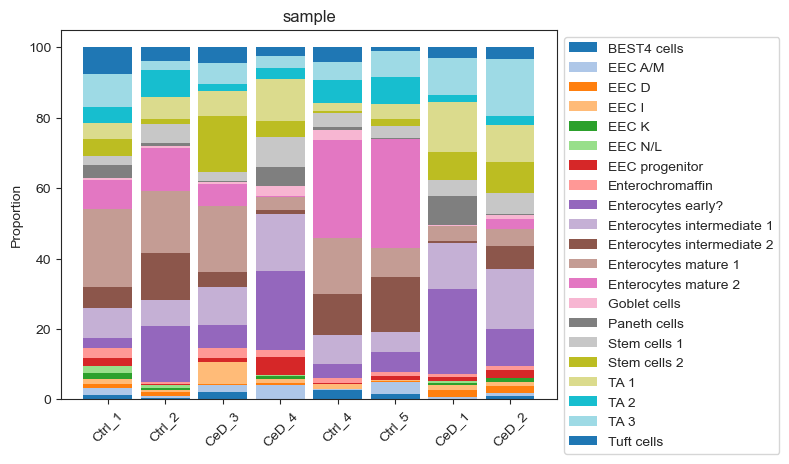

In [31]:
viz.stacked_barplot(data_all, feature_name = 'sample')

<AxesSubplot:title={'center':'Condition'}, ylabel='Proportion'>

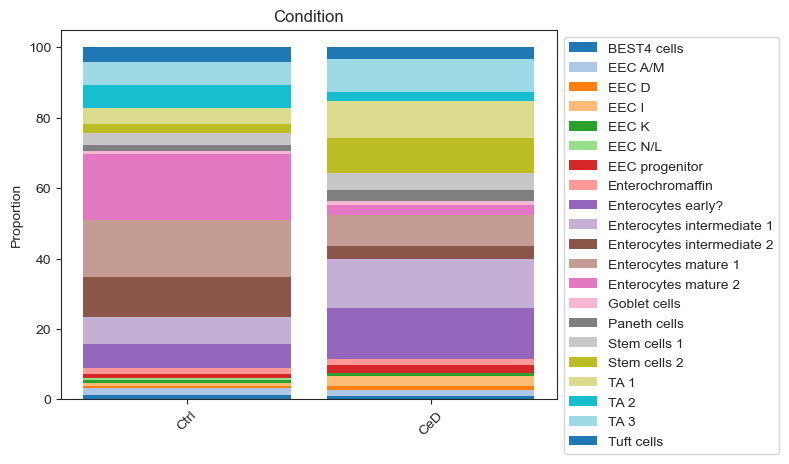

In [32]:
viz.stacked_barplot(data_all, feature_name = 'Condition')

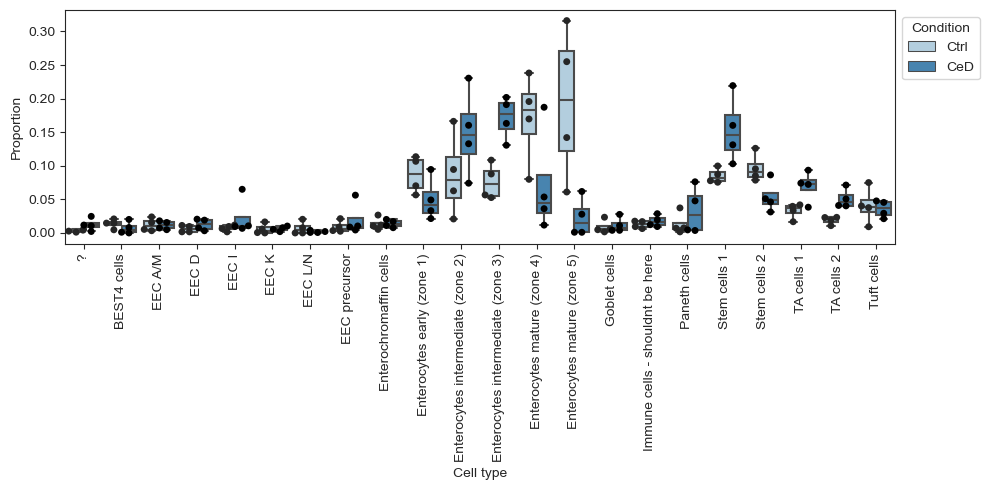

In [14]:
viz.boxplots(data_all, feature_name="Condition", figsize = (10,5), add_dots = True)
plt.show()

In [15]:
print(sim_results.credible_effects())

Covariate                               Cell Type                        
C(Condition, Treatment('Ctrl'))[T.CeD]  ?                                    False
                                        BEST4 cells                          False
                                        EEC A/M                              False
                                        EEC D                                False
                                        EEC I                                False
                                        EEC K                                False
                                        EEC L/N                              False
                                        EEC precursor                        False
                                        Enterochromaffin cells               False
                                        Enterocytes early (zone 1)           False
                                        Enterocytes intermediate (zone 2)    False
             

## Trying including the covariates in the model
Covariates: batch, sex, age, condition (status)

In [4]:
# Loading the dataset
cell_counts = pd.read_csv('../subclustering/outputs/epithelial_cells_counts.csv')
cell_counts

,sample,age,sex,batch,status,?,EEC A/M,EEC D,EEC I,EEC K,...,Enterocytes mature (zone 4),Enterocytes mature (zone 5),Goblet cells,Paneth cells,Stem cells 1,Stem cells 2,TA cells 1,TA cells 2,Tuft cells,BEST4 cells
0,CeD1,10,M,A,CeD,12,5,21,7,8,...,37,1,4,78,164,32,74,73,30,0
1,CeD2,14,F,A,CeD,3,8,22,10,11,...,55,21,11,5,144,39,49,45,58,8
2,CeD2,14,F,F,CeD,0,2,4,3,3,...,18,17,4,0,155,24,52,24,7,3
3,CeD3,14,F,A,CeD,38,24,5,100,3,...,288,95,6,7,202,133,59,63,70,31
4,CeD4,17,F,A,CeD,9,11,4,3,1,...,8,1,15,39,75,38,47,22,11,0
5,CeD4,17,F,F,CeD,1,6,3,7,4,...,3,0,11,6,22,10,41,16,9,1
6,Ctrl1,15,F,A,Ctrl,9,16,8,11,31,...,316,98,6,55,78,103,28,19,100,20
7,Ctrl1,15,F,F,Ctrl,2,16,12,9,3,...,176,28,4,22,128,73,41,29,55,10
8,Ctrl2,11,M,F,Ctrl,2,9,19,11,10,...,288,241,10,12,148,162,71,39,64,8
9,Ctrl4,12,M,A,Ctrl,5,4,2,14,0,...,234,305,28,9,93,94,20,13,48,25


In [5]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns = ['sample', 'age', 'sex', 'batch', 'status'])
print(data_all.obs)

   sample  age sex batch status
0    CeD1   10   M     A    CeD
1    CeD2   14   F     A    CeD
2    CeD2   14   F     F    CeD
3    CeD3   14   F     A    CeD
4    CeD4   17   F     A    CeD
5    CeD4   17   F     F    CeD
6   Ctrl1   15   F     A   Ctrl
7   Ctrl1   15   F     F   Ctrl
8   Ctrl2   11   M     F   Ctrl
9   Ctrl4   12   M     A   Ctrl
10  Ctrl5   15   F     A   Ctrl


<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

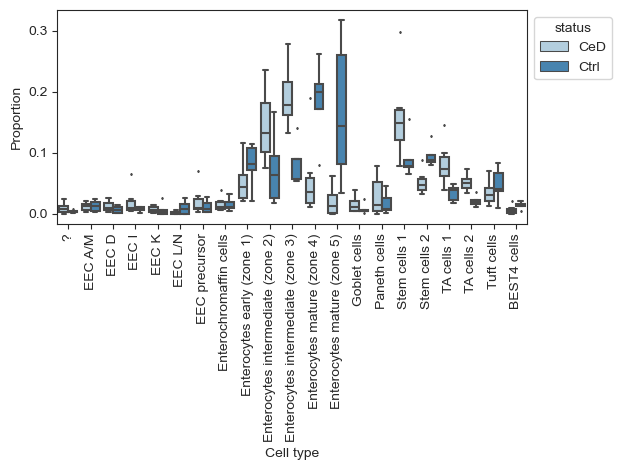

In [7]:
viz.boxplots(data_all, feature_name = 'status')

In [18]:
# Define model
model_complete = mod.CompositionalAnalysis(data_all, formula = "age + sex + batch + status", reference_cell_type = "automatic")
model_sex = mod.CompositionalAnalysis(data_all, formula = "sex", reference_cell_type = "automatic")
model_batch = mod.CompositionalAnalysis(data_all, formula = "batch", reference_cell_type = "automatic")

Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.
Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.
Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.


In [10]:
# Run 
results = model_complete.sample_hmc()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:47<00:00, 186.51it/s]


MCMC sampling finished. (142.729 sec)
Acceptance rate: 78.3%


In [19]:
results_sex = model_sex.sample_hmc()

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:33<00:00, 213.68it/s]


MCMC sampling finished. (119.232 sec)
Acceptance rate: 51.0%


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:27<00:00, 227.46it/s]


MCMC sampling finished. (111.416 sec)
Acceptance rate: 58.4%


In [14]:
results.summary()

Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: age + sex + batch + status

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.343        10.111139
EEC A/M                                      0.048        14.948900
EEC D                                        0.334        19.898368
EEC I                                       -0.007        14.148912
EEC K                                       -0.555         8.179555
EEC L/N                                     -1.215         4.227614
EEC precursor                               -0.235        11.264292
Enterochromaffin cells                       0.063        15.174824
Enterocytes early (zone 1)                   1.180        46.369305
Enterocytes intermediate (zone 2)            3.066       305.710235
Enterocytes intermediate (zone 3)            2.326 

In [17]:
pd.DataFrame.to_csv(results.effect_df, 'results_effect_summary.csv')

In [20]:
results_sex.summary()

Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: sex

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.697        14.645909
EEC A/M                                     -0.291        21.980618
EEC D                                       -0.473        18.323073
EEC I                                       -0.341        20.908611
EEC K                                       -0.744        13.973477
EEC L/N                                     -0.984        10.991927
EEC precursor                               -0.276        22.312812
Enterochromaffin cells                      -0.153        25.233212
Enterocytes early (zone 1)                   0.851        68.865895
Enterocytes intermediate (zone 2)            1.272       104.916108
Enterocytes intermediate (zone 3)            1.611       147.254306
Entero

In [22]:
results_batch = model_batch.sample_hmc()
results_batch.summary()

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:34<00:00, 212.39it/s]


MCMC sampling finished. (120.069 sec)
Acceptance rate: 90.2%
Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: batch

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.642        15.481359
EEC A/M                                     -0.272        22.412899
EEC D                                       -0.457        18.627456
EEC I                                       -0.365        20.422488
EEC K                                       -0.754        13.841020
EEC L/N                                     -0.980        11.041232
EEC precursor                               -0.298        21.837674
Enterochromaffin cells                      -0.142        25.524445
Enterocytes early (zone 1)                   0.851        68.898654
Enterocytes intermediate (zone 2)            1.294       107.300857
Enterocytes

In [23]:
model_complete_2 = mod.CompositionalAnalysis(data_all, formula = "(age + sex + batch) + status", reference_cell_type = "automatic")
results_complete_2 = model_complete_2.sample_hmc()
results_complete_2.summary()

Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:37<00:00, 206.01it/s]


MCMC sampling finished. (123.770 sec)
Acceptance rate: 32.3%
Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: (age + sex + batch) + status

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.379        13.255856
EEC A/M                                     -0.056        18.309855
EEC D                                       -0.034        18.717136
EEC I                                       -0.027        18.848615
EEC K                                       -0.767         8.992937
EEC L/N                                     -1.475         4.430177
EEC precursor                               -0.166        16.402593
Enterochromaffin cells                      -0.277        14.679316
Enterocytes early (zone 1)                   1.071        56.511234
Enterocytes intermediate (zone 2)            2.253      

In [24]:
pd.DataFrame.to_csv(results_complete_2.effect_df, 'results_effect_summary_2.csv')

In [6]:
model_status = mod.CompositionalAnalysis(data_all, formula = "C(status, Treatment('Ctrl'))", reference_cell_type = "automatic")
results_status = model_status.sample_hmc()
results_status.summary()
pd.DataFrame.to_csv(results_status.effect_df, 'results_effect_summary_onlystatus.csv')

Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:38<00:00, 203.62it/s]


MCMC sampling finished. (128.960 sec)
Acceptance rate: 52.2%
Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: C(status, Treatment('Ctrl'))

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.546        10.292436
EEC A/M                                     -0.028        17.277572
EEC D                                       -0.298        13.189344
EEC I                                       -0.153        15.247404
EEC K                                       -0.587         9.878980
EEC L/N                                     -0.743         8.452052
EEC precursor                               -0.050        16.901616
Enterochromaffin cells                       0.123        20.093758
Enterocytes early (zone 1)                   1.402        72.197776
Enterocytes intermediate (zone 2)            1.393      

In [27]:
results.set_fdr(est_fdr = 0.2)
results.summary()

pd.DataFrame.to_csv(results.effect_df, 'results_effect_summary_FDR02.csv')

Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: age + sex + batch + status

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.343        10.111139
EEC A/M                                      0.048        14.948900
EEC D                                        0.334        19.898368
EEC I                                       -0.007        14.148912
EEC K                                       -0.555         8.179555
EEC L/N                                     -1.215         4.227614
EEC precursor                               -0.235        11.264292
Enterochromaffin cells                       0.063        15.174824
Enterocytes early (zone 1)                   1.180        46.369305
Enterocytes intermediate (zone 2)            3.066       305.710235
Enterocytes intermediate (zone 3)            2.326 

In [4]:
# Changing the order of the formula to status + batch + sex + age
model_complete3 = mod.CompositionalAnalysis(data_all, formula = "C(status, Treatment('Ctrl')) + age + sex + batch", reference_cell_type = "automatic")
results_complete3 = model_complete3.sample_hmc()
results_complete3.summary()

Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:44<00:00, 191.35it/s]


MCMC sampling finished. (135.488 sec)
Acceptance rate: 46.5%
Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: C(status, Treatment('Ctrl')) + age + sex + batch

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.497        10.160729
EEC A/M                                      0.022        17.073545
EEC D                                       -0.284        12.572730
EEC I                                       -0.142        14.491035
EEC K                                       -0.494        10.191257
EEC L/N                                     -0.791         7.572552
EEC precursor                               -0.210        13.538401
Enterochromaffin cells                       0.116        18.756309
Enterocytes early (zone 1)                   1.479        73.297770
Enterocytes intermediate (zone 2)   

In [5]:
pd.DataFrame.to_csv(results_complete3.effect_df, 'results_effect_summary_v3.csv')

In [7]:
model_status_batch = mod.CompositionalAnalysis(data_all, formula = "C(status, Treatment('Ctrl')) + batch", reference_cell_type = "automatic")
results_status_batch = model_status_batch.sample_hmc()
results_status_batch.summary()
pd.DataFrame.to_csv(results_status_batch.effect_df, 'results_effect_summary_status_batch.csv')

Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:36<00:00, 208.16it/s]


MCMC sampling finished. (125.637 sec)
Acceptance rate: 70.0%
Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: C(status, Treatment('Ctrl')) + batch

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.505        10.551632
EEC A/M                                     -0.000        17.483902
EEC D                                       -0.291        13.069491
EEC I                                       -0.114        15.600151
EEC K                                       -0.586         9.730649
EEC L/N                                     -0.732         8.408815
EEC precursor                               -0.027        17.018153
Enterochromaffin cells                       0.165        20.620394
Enterocytes early (zone 1)                   1.426        72.768312
Enterocytes intermediate (zone 2)            1.3

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

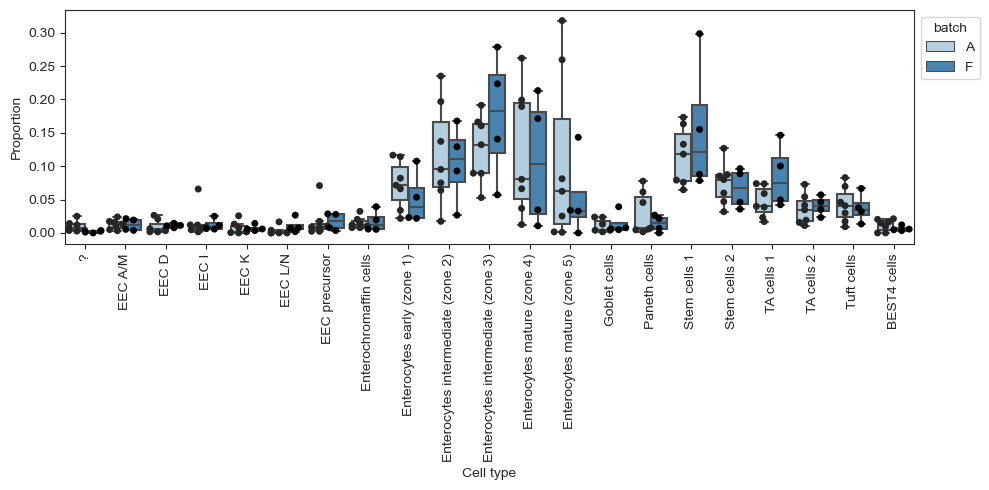

In [9]:
viz.boxplots(data_all, feature_name = 'batch', figsize = (10,5), add_dots = True)

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

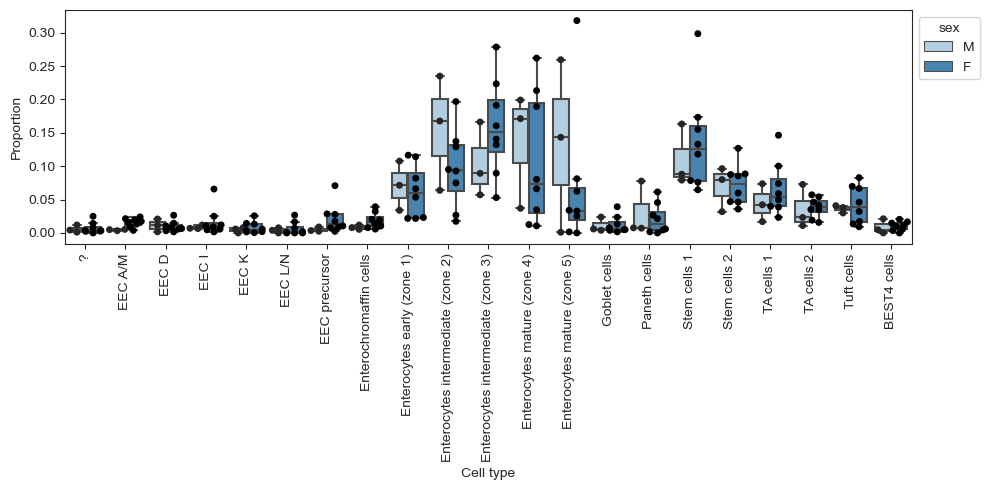

In [10]:
viz.boxplots(data_all, feature_name = 'sex', figsize = (10,5), add_dots = True)

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

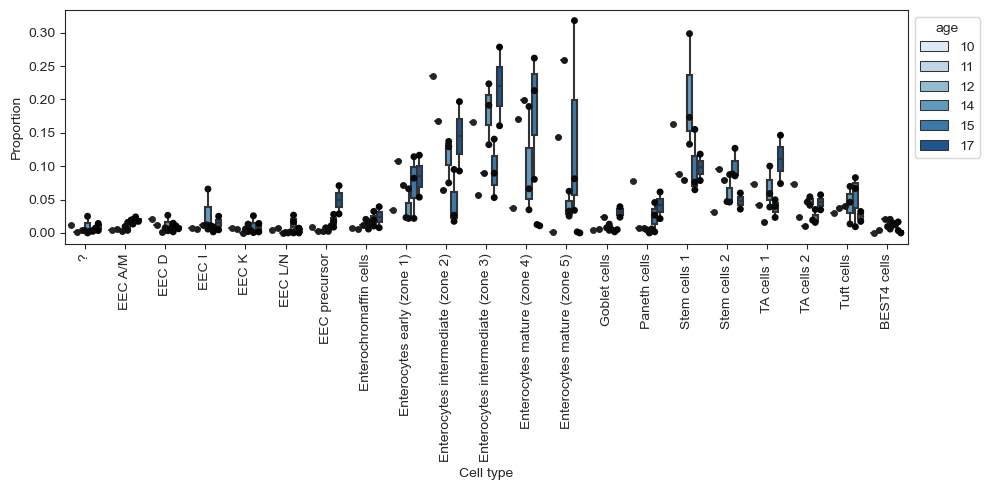

In [11]:
viz.boxplots(data_all, feature_name = 'age', figsize = (10,5), add_dots = True)

In [6]:
# Trying the complete model with HMC chain length = 150,000 and burn-in = 10,000
model_complete4 = mod.CompositionalAnalysis(data_all, formula = "~C(status, Treatment('Ctrl')) + age + sex + batch", reference_cell_type = "automatic")
results_complete4 = model_complete4.sample_hmc(num_results = 150000, num_burnin = 10000)
results_complete4.summary()
pd.DataFrame.to_csv(results_complete4.effect_df, 'results_effect_summary_v4.csv')

Automatic reference selection! Reference cell type set to EEC A/M
Zero counts encountered in data! Added a pseudocount of 0.5.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|█████████████████████████████████████████████████████████████████████████| 150000/150000 [14:29<00:00, 172.53it/s]


KeyboardInterrupt: 

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

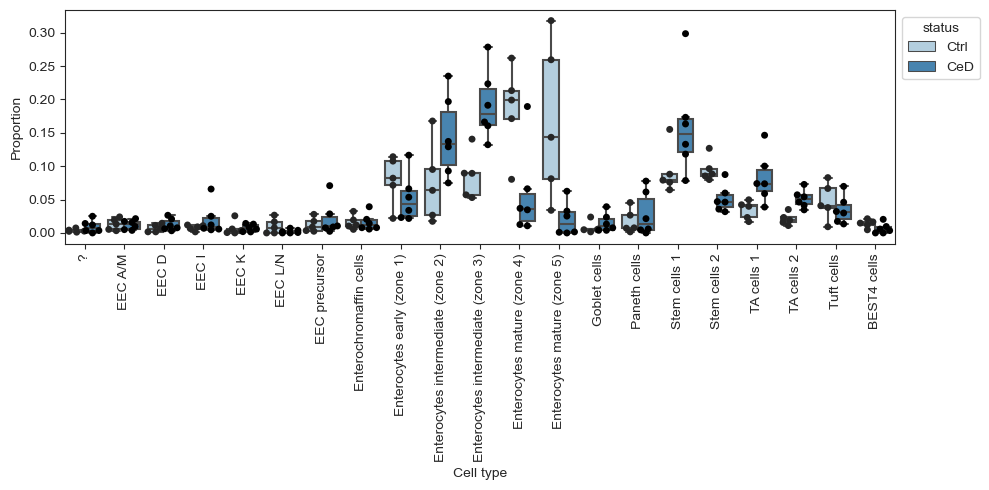

In [16]:
viz.boxplots(data_all, feature_name = 'status', figsize = (10,5), add_dots = True, level_order = ('Ctrl', 'CeD'))

In [18]:
# Checking FDR = 0.2
results_complete4.set_fdr(est_fdr = 0.2)
results_complete4.summary()
pd.DataFrame.to_csv(results_complete4.effect_df, 'results_effect_summary_v4_FDR02.csv')

Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: C(status, Treatment('Ctrl')) + age + sex + batch

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.456         9.559936
EEC A/M                                      0.056        15.951950
EEC D                                       -0.284        11.354125
EEC I                                       -0.230        11.984104
EEC K                                       -0.804         6.750260
EEC L/N                                     -0.797         6.797678
EEC precursor                               -0.042        14.462818
Enterochromaffin cells                       0.012        15.265282
Enterocytes early (zone 1)                   1.528        69.517678
Enterocytes intermediate (zone 2)            1.754        87.145669
Enterocytes intermediate (zon

In [19]:
results_complete5 = model_complete4.sample_hmc(num_results = 400000, num_burnin = 10000)
results_complete5.summary()
pd.DataFrame.to_csv(results_complete5.effect_df, 'results_effect_summary_v5.csv')

100%|█████████████████████████████████████████████████████████████████████████| 400000/400000 [33:59<00:00, 196.10it/s]


MCMC sampling finished. (2098.232 sec)
Acceptance rate: 8.7%
Compositional Analysis summary:

Data: 11 samples, 21 cell types
Reference index: 1
Formula: C(status, Treatment('Ctrl')) + age + sex + batch

Intercepts:
                                   Final Parameter  Expected Sample
Cell Type                                                          
?                                           -0.528         8.738039
EEC A/M                                      0.474        23.800004
EEC D                                       -0.573         8.353543
EEC I                                       -0.071        13.800237
EEC K                                       -1.205         4.440139
EEC L/N                                     -0.550         8.547901
EEC precursor                               -0.378        10.152152
Enterochromaffin cells                       0.246        18.947760
Enterocytes early (zone 1)                   1.670        78.703352
Enterocytes intermediate (zone 2)   